In [148]:
import re
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict
from string import punctuation
from unicodedata import normalize

from pandas import read_csv, DataFrame, Series
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

In [2]:
reviews = read_csv('./datasets/amazon_vfl_reviews.csv')

In [3]:
reviews

asin                                     name        date  rating  \
0     B07W7CTLD1  Mamaearth-Onion-Growth-Control-Redensyl  2019-09-06       1   
1     B07W7CTLD1  Mamaearth-Onion-Growth-Control-Redensyl  2019-08-14       5   
2     B07W7CTLD1  Mamaearth-Onion-Growth-Control-Redensyl  2019-10-19       1   
3     B07W7CTLD1  Mamaearth-Onion-Growth-Control-Redensyl  2019-09-16       1   
4     B07W7CTLD1  Mamaearth-Onion-Growth-Control-Redensyl  2019-08-18       5   
...          ...                                      ...         ...     ...   
2777  B07MVHJ6CH            Mysore-Sandal-Soaps-Pack-Bars  2020-03-01       5   
2778  B07MVHJ6CH            Mysore-Sandal-Soaps-Pack-Bars  2019-10-24       5   
2779  B07MVHJ6CH            Mysore-Sandal-Soaps-Pack-Bars  2020-10-03       2   
2780  B07MVHJ6CH            Mysore-Sandal-Soaps-Pack-Bars  2019-06-21       4   
2781  B07MVHJ6CH            Mysore-Sandal-Soaps-Pack-Bars  2020-07-03       5   

                                                 review  
0     I bought this hair oil after viewing so many g...  
1     Used This Mama Earth Newly Launched Onion Oil ...  
2     So bad product...My hair falling increase too ...  
3     Product just smells similar to navarathna hair...  
4     I have been trying different onion oil for my ...  
...                                                 ...  
2777         Long lasting freshness throughout the day.  
2778                                  My preferred soap  
2779                                       ठीक नहीं लगा  
2780                                      Super Product  
2781  Best soothing, cooling fragrance for hot summe...  

[2782 rows x 5 columns]

In [12]:
for index, row in reviews.review.iteritems():
    try:
        lang = detect(row)
    except: 
        lang = np.nan
    reviews.loc[index, 'lang'] = lang

In [13]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2782 entries, 0 to 2781
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   asin    2782 non-null   object
 1   name    2782 non-null   object
 2   date    2782 non-null   object
 3   rating  2782 non-null   int64 
 4   review  2778 non-null   object
 5   lang    2774 non-null   object
dtypes: int64(1), object(5)
memory usage: 130.5+ KB


In [16]:
reviews = reviews[ ~reviews.lang.isna() ]

In [17]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2774 entries, 0 to 2781
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   asin    2774 non-null   object
 1   name    2774 non-null   object
 2   date    2774 non-null   object
 3   rating  2774 non-null   int64 
 4   review  2774 non-null   object
 5   lang    2774 non-null   object
dtypes: int64(1), object(5)
memory usage: 151.7+ KB


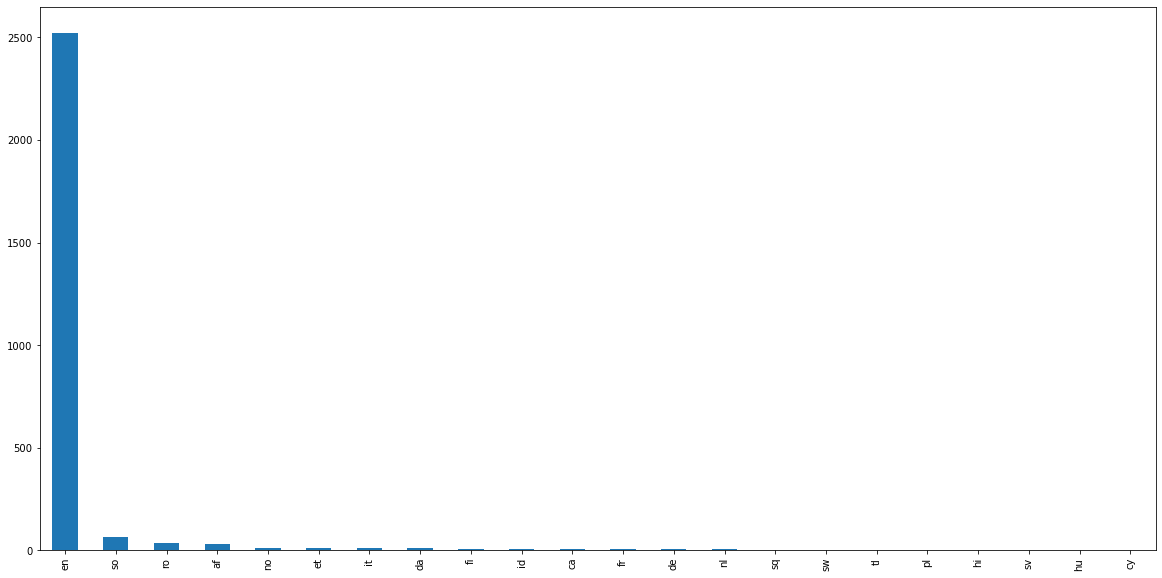

In [22]:
plt.figure(figsize=(20,10))
reviews.lang.value_counts().plot(kind='bar')
plt.show()

In [23]:
reviews = reviews[ reviews.lang == 'en' ]

In [24]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2522 entries, 0 to 2781
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   asin    2522 non-null   object
 1   name    2522 non-null   object
 2   date    2522 non-null   object
 3   rating  2522 non-null   int64 
 4   review  2522 non-null   object
 5   lang    2522 non-null   object
dtypes: int64(1), object(5)
memory usage: 137.9+ KB


In [59]:
reviews.drop(columns=['asin', 'name', 'date', 'lang'], inplace=True)

In [46]:
STOPWORDS = stopwords.words("english")
TOKENIZER = WordPunctTokenizer()
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()
PUNCTS = r'|'.join([re.escape(punct) for punct in punctuation ])

In [53]:
def to_lower(input_text: str) -> str:
    return input_text.lower()

def remove_blank_lines(input_text: str) -> str:
    return re.sub('\n', '', input_text)

def remove_punctuation(input_text: str) -> str: 
    return re.sub(  '(' + PUNCTS + ')', ' ', input_text)

def remove_accents(input_text: str) -> str: 
    return normalize('NFKD', input_text).encode('ASCII', 'ignore').decode('utf-8')

def decompose_word(input_text: str) -> str: 
    return re.sub(r'\b(\w+)\b-\b(\w+)\b', r'\1 \2', input_text)

def trim_text(input_text: str) -> str: 
    return input_text.strip()

In [54]:
def preprocessing(input_text: str) -> str:
    lowered = to_lower(input_text)
    without_blank_lines = remove_blank_lines(lowered)
    without_punctuations = remove_punctuation(without_blank_lines)
    without_accents = remove_accents(without_punctuations)
    decomposed = decompose_word(without_accents)
    
    return trim_text(decomposed)

In [56]:
reviews['proccessed_text'] = reviews.review.apply(preprocessing)

In [60]:
reviews

rating                                             review  \
0          1  I bought this hair oil after viewing so many g...   
1          5  Used This Mama Earth Newly Launched Onion Oil ...   
2          1  So bad product...My hair falling increase too ...   
3          1  Product just smells similar to navarathna hair...   
4          5  I have been trying different onion oil for my ...   
...      ...                                                ...   
2775       5  Been using it for 45 years . The best soap ever .   
2777       5         Long lasting freshness throughout the day.   
2778       5                                  My preferred soap   
2780       4                                      Super Product   
2781       5  Best soothing, cooling fragrance for hot summe...   

                                        proccessed_text  
0     i bought this hair oil after viewing so many g...  
1     used this mama earth newly launched onion oil ...  
2     so bad product   my hair falling increase too ...  
3     product just smells similar to navarathna hair...  
4     i have been trying different onion oil for my ...  
...                                                 ...  
2775    been using it for 45 years   the best soap ever  
2777          long lasting freshness throughout the day  
2778                                  my preferred soap  
2780                                      super product  
2781  best soothing  cooling fragrance for hot summe...  

[2522 rows x 3 columns]

In [93]:
def extract_polarity(input_text: str) -> Tuple[float, float]:
    polarity, _ = TextBlob(input_text).sentiment
    
    return polarity

def extract_subjectivity(input_text: str) -> Tuple[float, float]:
    _, subjectivity = TextBlob(input_text).sentiment
    
    return subjectivity


In [94]:
reviews['polarity'] = reviews.proccessed_text.apply(extract_polarity)
reviews['subjectivity'] = reviews.proccessed_text.apply(extract_subjectivity)

In [95]:
reviews

rating                                             review  \
0          1  I bought this hair oil after viewing so many g...   
1          5  Used This Mama Earth Newly Launched Onion Oil ...   
2          1  So bad product...My hair falling increase too ...   
3          1  Product just smells similar to navarathna hair...   
4          5  I have been trying different onion oil for my ...   
...      ...                                                ...   
2775       5  Been using it for 45 years . The best soap ever .   
2777       5         Long lasting freshness throughout the day.   
2778       5                                  My preferred soap   
2780       4                                      Super Product   
2781       5  Best soothing, cooling fragrance for hot summe...   

                                        proccessed_text  polarity  \
0     i bought this hair oil after viewing so many g...  0.016270   
1     used this mama earth newly launched onion oil ...  0.327189   
2     so bad product   my hair falling increase too ... -0.400000   
3     product just smells similar to navarathna hair...  0.010417   
4     i have been trying different onion oil for my ...  0.286813   
...                                                 ...       ...   
2775    been using it for 45 years   the best soap ever  1.000000   
2777          long lasting freshness throughout the day -0.025000   
2778                                  my preferred soap  0.000000   
2780                                      super product  0.333333   
2781  best soothing  cooling fragrance for hot summe...  0.466667   

      subjectivity  
0         0.463492  
1         0.499484  
2         0.511111  
3         0.547917  
4         0.626374  
...            ...  
2775      0.300000  
2777      0.200000  
2778      0.000000  
2780      0.666667  
2781      0.720000  

[2522 rows x 5 columns]

In [113]:
reviews.groupby(by='rating').mean()

polarity  subjectivity
rating                        
1      -0.058307      0.481123
2       0.079051      0.472448
3       0.165173      0.515578
4       0.306753      0.559032
5       0.376396      0.561905

In [193]:
from functools import partial


SENTIMENT_ANALYZER = SentimentIntensityAnalyzer()

def extract_sentiment(target: str, row: Series) -> Series:
    text = row[target]
    score = SENTIMENT_ANALYZER.polarity_scores(text)
    
    neg = score['neg']
    pos = score['pos']
    neu = score['neu']
    
    row['pos'] = pos
    row['neg'] = neg
    row['neu'] = neu    
    
    if neu >= 0.72:
        row['sentiment'] = 'neutral'
    elif neg > pos:
        row['sentiment'] = 'negative'
    else:
        row['sentiment'] = 'positive'

    
    return row
    

In [194]:
extract_sentiment_from_proccessed_text = partial(extract_sentiment, 'proccessed_text')

reviews = reviews.apply(extract_sentiment_from_proccessed_text, axis=1)

In [195]:
reviews

rating                                             review  \
0          1  I bought this hair oil after viewing so many g...   
1          5  Used This Mama Earth Newly Launched Onion Oil ...   
2          1  So bad product...My hair falling increase too ...   
3          1  Product just smells similar to navarathna hair...   
4          5  I have been trying different onion oil for my ...   
...      ...                                                ...   
2775       5  Been using it for 45 years . The best soap ever .   
2777       5         Long lasting freshness throughout the day.   
2778       5                                  My preferred soap   
2780       4                                      Super Product   
2781       5  Best soothing, cooling fragrance for hot summe...   

                                        proccessed_text  \
0     i bought this hair oil after viewing so many g...   
1     used this mama earth newly launched onion oil ...   
2     so bad product   my hair falling increase too ...   
3     product just smells similar to navarathna hair...   
4     i have been trying different onion oil for my ...   
...                                                 ...   
2775    been using it for 45 years   the best soap ever   
2777          long lasting freshness throughout the day   
2778                                  my preferred soap   
2780                                      super product   
2781  best soothing  cooling fragrance for hot summe...   

                                              stemmezed    pos    neg    neu  \
0     bought hair oil view mani good comment good en...  0.172  0.106  0.722   
1     use mama earth newli launch onion oil twice mu...  0.185  0.074  0.741   
2     bad hair fall increas much order shampoo mask ...  0.126  0.331  0.543   
3     smell similar navarathna hair oil strong oil s...  0.113  0.221  0.666   
4     tri differ onion oil hair hair healthi liter c...  0.168  0.035  0.798   
...                                                 ...    ...    ...    ...   
2775                         use 45 year best soap ever  0.318  0.000  0.682   
2777                     long last fresh throughout day  0.000  0.000  1.000   
2778                                        prefer soap  0.000  0.000  1.000   
2780                                              super  0.796  0.000  0.204   
2781  best sooth cool fragranc hot summer month soap...  0.320  0.000  0.680   

     sentiment  
0      neutral  
1      neutral  
2     negative  
3     negative  
4      neutral  
...        ...  
2775  positive  
2777   neutral  
2778   neutral  
2780  positive  
2781  positive  

[2522 rows x 8 columns]

In [198]:
reviews.sentiment.mode()

0    neutral
dtype: object

In [211]:
reviews.groupby(by=['rating','sentiment'])['review'].count()

rating  sentiment
1       negative     104
        neutral      390
        positive      36
2       negative      10
        neutral       88
        positive      21
3       negative      12
        neutral      136
        positive      30
4       negative      10
        neutral      253
        positive     146
5       negative      24
        neutral      595
        positive     667
Name: review, dtype: int64

In [123]:
reviews.iloc[0].proccessed_text

'i bought this hair oil after viewing so many good comments  but this product is not good enough first of all it s expensive   second thing the amount of the product is low  half bottle  yes the bottle is not completely filled with oil  if you cheating on your customers  mamaearth trust me on this you can t fool people more than once  now i know that your brand is not good enough  i am not going to buy any product from your brand again thumbs down for mamaearth onion oil'

In [133]:
import matplotlib.pyplot as plt
from pandas import Series
from wordcloud import WordCloud
from PIL import Image

def generate_word_cloud(texts: Series):
    whole_text = ' '.join(texts.to_list())
    mask = np.array(Image.open('./cloud.png'))
    wordcloud = WordCloud(width=1024, height=768,  max_words=2000, contour_color='steelblue', background_color='white', mask=mask, stopwords=STOPWORDS).generate(whole_text)
    
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

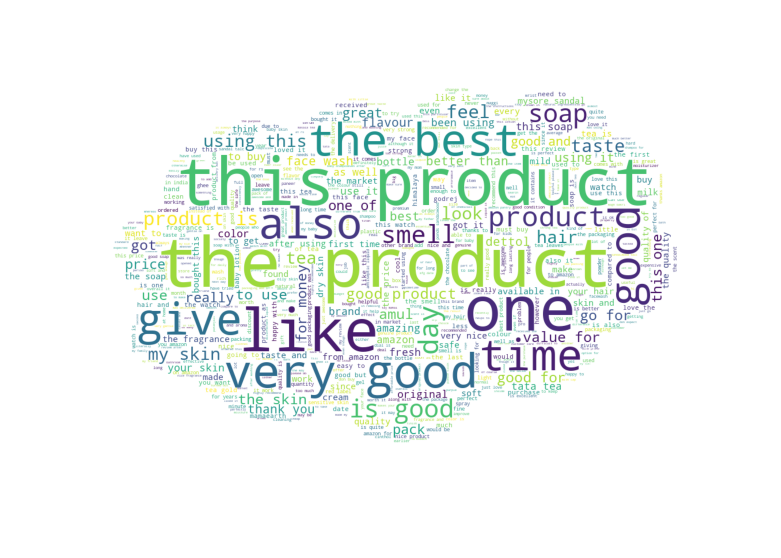

In [134]:
generate_word_cloud(reviews[reviews.sentiment == 'positive'].proccessed_text)

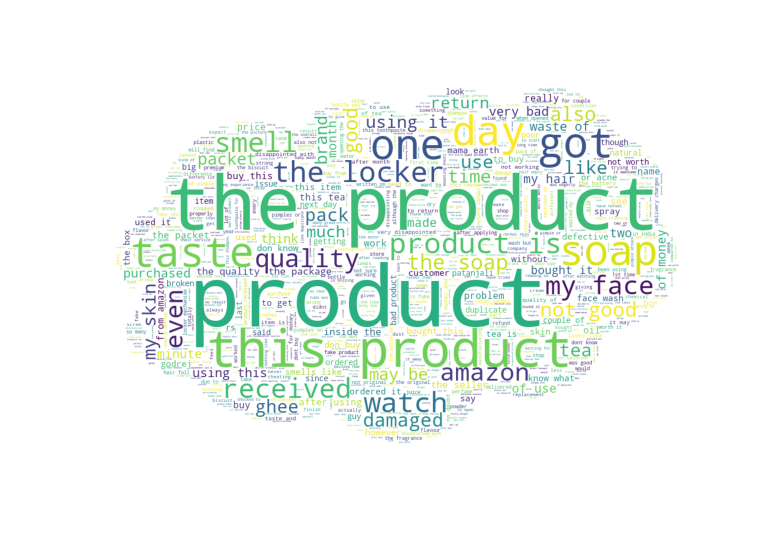

In [135]:
generate_word_cloud(reviews[reviews.sentiment == 'negative'].proccessed_text)

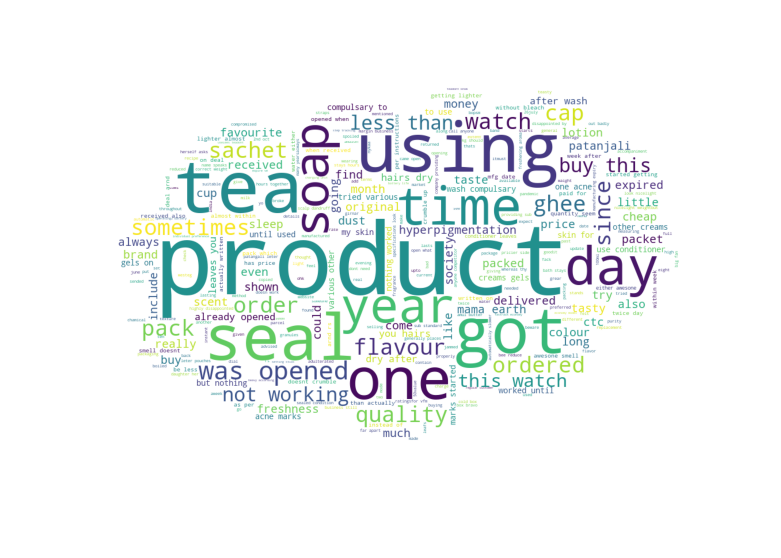

In [136]:
generate_word_cloud(reviews[reviews.sentiment == 'neutral'].proccessed_text)

In [184]:
def is_not_a_stopword(word: str) -> bool:
    return not word in STOPWORDS + ['product', 'one']

def stemmer(input_text: str) -> str: 
    tokens = TOKENIZER.tokenize(input_text)
    
    result = [STEMMER.stem(word) for word in tokens if is_not_a_stopword(word)]
    
    return trim_text(' '.join(result))

In [185]:
reviews['stemmezed'] = reviews.proccessed_text.apply(stemmer)

In [186]:
reviews.drop(columns=['pos', 'neg', 'neu', 'sentiment'], inplace=True)

In [187]:
reviews

rating                                             review  \
0          1  I bought this hair oil after viewing so many g...   
1          5  Used This Mama Earth Newly Launched Onion Oil ...   
2          1  So bad product...My hair falling increase too ...   
3          1  Product just smells similar to navarathna hair...   
4          5  I have been trying different onion oil for my ...   
...      ...                                                ...   
2775       5  Been using it for 45 years . The best soap ever .   
2777       5         Long lasting freshness throughout the day.   
2778       5                                  My preferred soap   
2780       4                                      Super Product   
2781       5  Best soothing, cooling fragrance for hot summe...   

                                        proccessed_text  \
0     i bought this hair oil after viewing so many g...   
1     used this mama earth newly launched onion oil ...   
2     so bad product   my hair falling increase too ...   
3     product just smells similar to navarathna hair...   
4     i have been trying different onion oil for my ...   
...                                                 ...   
2775    been using it for 45 years   the best soap ever   
2777          long lasting freshness throughout the day   
2778                                  my preferred soap   
2780                                      super product   
2781  best soothing  cooling fragrance for hot summe...   

                                              stemmezed  
0     bought hair oil view mani good comment good en...  
1     use mama earth newli launch onion oil twice mu...  
2     bad hair fall increas much order shampoo mask ...  
3     smell similar navarathna hair oil strong oil s...  
4     tri differ onion oil hair hair healthi liter c...  
...                                                 ...  
2775                         use 45 year best soap ever  
2777                     long last fresh throughout day  
2778                                        prefer soap  
2780                                              super  
2781  best sooth cool fragranc hot summer month soap...  

[2522 rows x 4 columns]

In [188]:
extract_sentiment_from_stemmezed = partial(extract_sentiment, 'stemmezed')

reviews = reviews.apply(extract_sentiment_from_stemmezed, axis=1)

In [189]:
reviews

rating                                             review  \
0          1  I bought this hair oil after viewing so many g...   
1          5  Used This Mama Earth Newly Launched Onion Oil ...   
2          1  So bad product...My hair falling increase too ...   
3          1  Product just smells similar to navarathna hair...   
4          5  I have been trying different onion oil for my ...   
...      ...                                                ...   
2775       5  Been using it for 45 years . The best soap ever .   
2777       5         Long lasting freshness throughout the day.   
2778       5                                  My preferred soap   
2780       4                                      Super Product   
2781       5  Best soothing, cooling fragrance for hot summe...   

                                        proccessed_text  \
0     i bought this hair oil after viewing so many g...   
1     used this mama earth newly launched onion oil ...   
2     so bad product   my hair falling increase too ...   
3     product just smells similar to navarathna hair...   
4     i have been trying different onion oil for my ...   
...                                                 ...   
2775    been using it for 45 years   the best soap ever   
2777          long lasting freshness throughout the day   
2778                                  my preferred soap   
2780                                      super product   
2781  best soothing  cooling fragrance for hot summe...   

                                              stemmezed    pos    neg    neu  \
0     bought hair oil view mani good comment good en...  0.231  0.154  0.615   
1     use mama earth newli launch onion oil twice mu...  0.236  0.102  0.663   
2     bad hair fall increas much order shampoo mask ...  0.000  0.289  0.711   
3     smell similar navarathna hair oil strong oil s...  0.133  0.143  0.723   
4     tri differ onion oil hair hair healthi liter c...  0.164  0.000  0.836   
...                                                 ...    ...    ...    ...   
2775                         use 45 year best soap ever  0.457  0.000  0.543   
2777                     long last fresh throughout day  0.365  0.000  0.635   
2778                                        prefer soap  0.000  0.000  1.000   
2780                                              super  1.000  0.000  0.000   
2781  best sooth cool fragranc hot summer month soap...  0.398  0.000  0.602   

     sentiment  
0     positive  
1     positive  
2     negative  
3     negative  
4     positive  
...        ...  
2775  positive  
2777  positive  
2778   neutral  
2780  positive  
2781  positive  

[2522 rows x 8 columns]

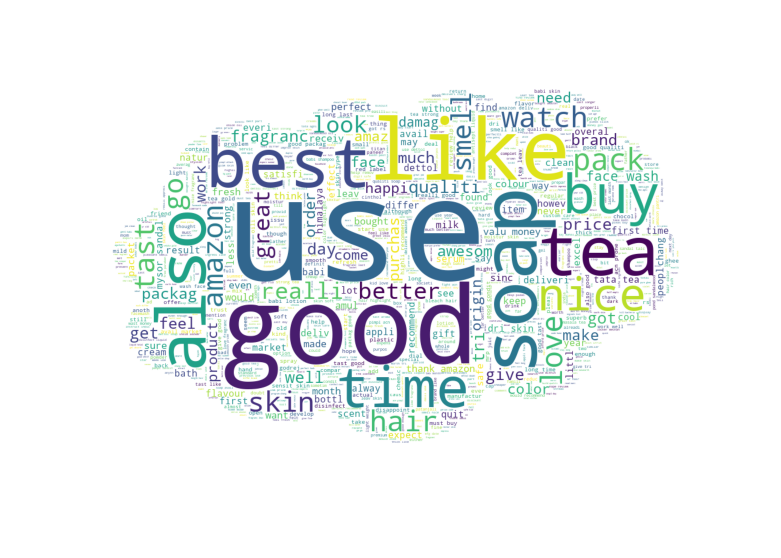

In [190]:
generate_word_cloud(reviews[reviews.sentiment == 'positive'].stemmezed)

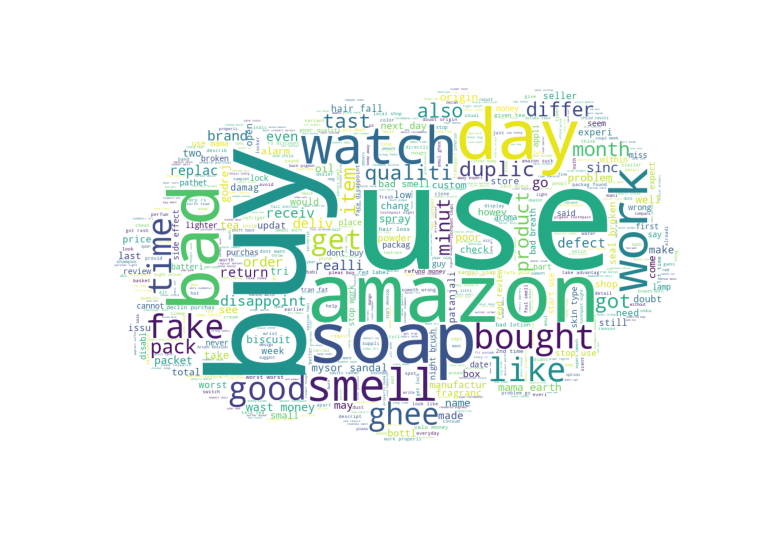

In [191]:
generate_word_cloud(reviews[reviews.sentiment == 'negative'].stemmezed)

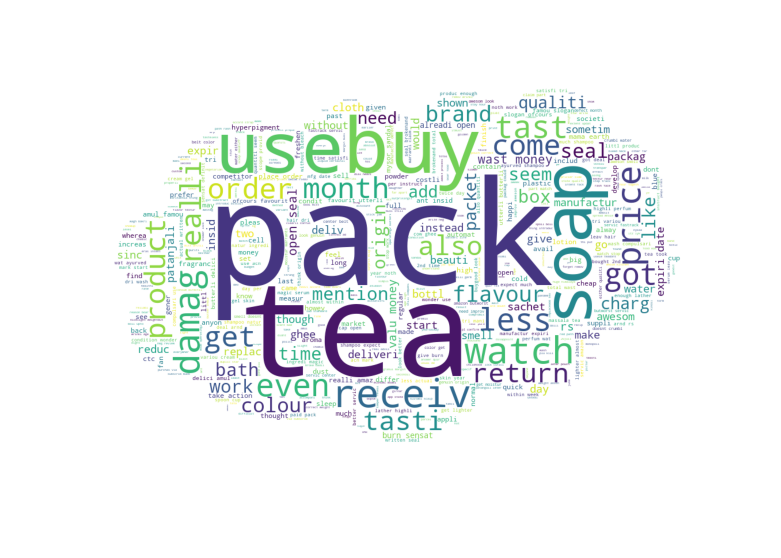

In [192]:
generate_word_cloud(reviews[reviews.sentiment == 'neutral'].stemmezed)